In [6]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
# !pip install neural_tangents
# !pip install networkx
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1700501338.8948317
Mon Nov 20 17:28:58 2023


Machine learning for quantum many-body problems
===============================================

::: {.meta}
:property=\"og:description\": Machine learning for many-body problems
:property=\"og:image\":
<https://pennylane.ai/qml/_images/ml_classical_shadow.png>
:::

::: {.related}
tutorial\_classical\_shadows Classical Shadows
tutorial\_kernel\_based\_training Kernel-based training with
scikit-learn tutorial\_kernels\_module Training and evaluating quantum
kernels
:::

*Author: Utkarsh Azad --- Posted: 02 May 2022. Last Updated: 09 May
2022*

Storing and processing a complete description of an $n$-qubit quantum
mechanical system is challenging because the amount of memory required
generally scales exponentially with the number of qubits. The quantum
community has recently addressed this challenge by using the
`classical shadow <tutorial_classical_shadows>`{.interpreted-text
role="doc"} formalism, which allows us to build more concise classical
descriptions of quantum states using randomized single-qubit
measurements. It was argued in Ref. that combining classical shadows
with classical machine learning enables using learning models that
efficiently predict properties of the quantum systems, such as the
expectation value of a Hamiltonian, correlation functions, and
entanglement entropies.

![Combining machine learning and classical
shadows](/demonstrations/ml_classical_shadows/class_shadow_ml.png){.align-center
width="80.0%"}

In this demo, we describe one of the ideas presented in Ref. for using
classical shadow formalism and machine learning to predict the
ground-state properties of the 2D antiferromagnetic Heisenberg model. We
begin by learning how to build the Heisenberg model, calculate its
ground-state properties, and compute its classical shadow. Finally, we
demonstrate how to use
`kernel-based learning models <tutorial_kernels_module>`{.interpreted-text
role="doc"} to predict ground-state properties from the learned
classical shadows. So let\'s get started!

Building the 2D Heisenberg Model
--------------------------------

We define a two-dimensional antiferromagnetic [Heisenberg
model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model) as a
square lattice, where a spin-1/2 particle occupies each site. The
antiferromagnetic nature and the overall physics of this model depend on
the couplings $J_{ij}$ present between the spins, as reflected in the
Hamiltonian associated with the model:

$$H = \sum_{i < j} J_{ij}(X_i X_j + Y_i Y_j + Z_i Z_j) .$$

Here, we consider the family of Hamiltonians where all the couplings
$J_{ij}$ are sampled uniformly from \[0, 2\]. We build a coupling matrix
$J$ by providing the number of rows $N_r$ and columns $N_c$ present in
the square lattice. The dimensions of this matrix are $N_s \times N_s$,
where $N_s = N_r \times N_c$ is the total number of spin particles
present in the model.


In [7]:
import itertools as it
import pennylane.numpy as np
import numpy as anp

def build_coupling_mats(num_mats, num_rows, num_cols):
    num_spins = num_rows * num_cols
    coupling_mats = np.zeros((num_mats, num_spins, num_spins))
    coup_terms = anp.random.RandomState(24).uniform(0, 2,
                        size=(num_mats, 2 * num_rows * num_cols - num_rows - num_cols))
    # populate edges to build the grid lattice
    edges = [(si, sj) for (si, sj) in it.combinations(range(num_spins), 2)
                        if sj % num_cols and sj - si == 1 or sj - si == num_cols]
    for itr in range(num_mats):
        for ((i, j), term) in zip(edges, coup_terms[itr]):
            coupling_mats[itr][i][j] = coupling_mats[itr][j][i] = term
    return coupling_mats

For this demo, we study a model with four spins arranged on the nodes of
a square lattice. We require four qubits for simulating this model; one
qubit for each spin. We start by building a coupling matrix `J_mat`
using our previously defined function.


In [8]:
Nr, Nc = 2, 2
num_qubits = Nr * Nc  # Ns
J_mat = build_coupling_mats(1, Nr, Nc)[0]

We can now visualize the model instance by representing the coupling
matrix as a `networkx` graph:


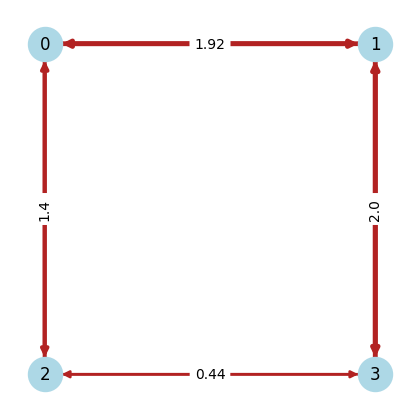

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.from_numpy_array(np.matrix(J_mat), create_using=nx.DiGraph)
pos = {i: (i % Nc, -(i // Nc)) for i in G.nodes()}
edge_labels = {(x, y): np.round(J_mat[x, y], 2) for x, y in G.edges()}
weights = [x + 1.5 for x in list(nx.get_edge_attributes(G, "weight").values())]

plt.figure(figsize=(4, 4))
nx.draw(
    G, pos, node_color="lightblue", with_labels=True,
    node_size=600, width=weights, edge_color="firebrick",
)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
plt.show()

We then use the same coupling matrix `J_mat` to obtain the Hamiltonian
$H$ for the model we have instantiated above.


In [10]:
import pennylane as qml

def Hamiltonian(J_mat):
    coeffs, ops = [], []
    ns = J_mat.shape[0]
    for i, j in it.combinations(range(ns), r=2):
        coeff = J_mat[i, j]
        if coeff:
            for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
                coeffs.append(coeff)
                ops.append(op(i) @ op(j))
    H = qml.Hamiltonian(coeffs, ops)
    return H

print(f"Hamiltonian =\n{Hamiltonian(J_mat)}")

Hamiltonian =
  (0.44013459956570355) [X2 X3]
+ (0.44013459956570355) [Y2 Y3]
+ (0.44013459956570355) [Z2 Z3]
+ (1.399024099899152) [X0 X2]
+ (1.399024099899152) [Y0 Y2]
+ (1.399024099899152) [Z0 Z2]
+ (1.920034606671837) [X0 X1]
+ (1.920034606671837) [Y0 Y1]
+ (1.920034606671837) [Z0 Z1]
+ (1.9997345852477584) [X1 X3]
+ (1.9997345852477584) [Y1 Y3]
+ (1.9997345852477584) [Z1 Z3]


For the Heisenberg model, a property of interest is usually the two-body
correlation function $C_{ij}$, which for a pair of spins $i$ and $j$ is
defined as the following operator:

$$\hat{C}_{ij} = \frac{1}{3} (X_i X_j + Y_iY_j + Z_iZ_j).$$


In [11]:
def corr_function(i, j):
    ops = []
    for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
        if i != j:
            ops.append(op(i) @ op(j))
        else:
            ops.append(qml.Identity(i))
    return ops

The expectation value of each such operator $\hat{C}_{ij}$ with respect
to the ground state $|\psi_{0}\rangle$ of the model can be used to build
the correlation matrix $C$:

$${C}_{ij} = \langle \hat{C}_{ij} \rangle = \frac{1}{3} \langle \psi_{0} | X_i X_j + Y_iY_j + Z_iZ_j | \psi_{0} \rangle .$$


Hence, to build $C$ for the model, we need to calculate its ground state
$|\psi_{0}\rangle$. We do this by diagonalizing the Hamiltonian for the
model. Then, we obtain the eigenvector corresponding to the smallest
eigenvalue.


In [12]:
import scipy as sp

ham = Hamiltonian(J_mat)
eigvals, eigvecs = sp.sparse.linalg.eigs(ham.sparse_matrix())
psi0 = eigvecs[:, np.argmin(eigvals)]

We then build a circuit that initializes the qubits into the ground
state and measures the expectation value of the provided set of
observables.


In [13]:
dev_exact = qml.device("lightning.qubit", wires=num_qubits) # for exact simulation

def circuit(psi, observables):
    psi = psi / np.linalg.norm(psi) # normalize the state
    qml.QubitStateVector(psi, wires=range(num_qubits))
    return [qml.expval(o) for o in observables]

circuit_exact = qml.QNode(circuit, dev_exact)

Finally, we execute this circuit to obtain the exact correlation matrix
$C$. We compute the correlation operators $\hat{C}_{ij}$ and their
expectation values with respect to the ground state $|\psi_0\rangle$.


In [14]:
coups = list(it.product(range(num_qubits), repeat=2))
corrs = [corr_function(i, j) for i, j in coups]

def build_exact_corrmat(coups, corrs, circuit, psi):
    corr_mat_exact = np.zeros((num_qubits, num_qubits))
    for idx, (i, j) in enumerate(coups):
        corr = corrs[idx]
        if i == j:
            corr_mat_exact[i][j] = 1.0
        else:
            corr_mat_exact[i][j] = (
                np.sum(np.array([circuit(psi, observables=[o]) for o in corr]).T) / 3
            )
            corr_mat_exact[j][i] = corr_mat_exact[i][j]
    return corr_mat_exact

expval_exact = build_exact_corrmat(coups, corrs, circuit_exact, psi0)

Once built, we can visualize the correlation matrix:


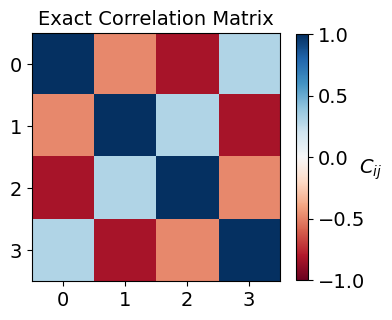

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(expval_exact, cmap=plt.get_cmap("RdBu"), vmin=-1, vmax=1)
ax.xaxis.set_ticks(range(num_qubits))
ax.yaxis.set_ticks(range(num_qubits))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title("Exact Correlation Matrix", fontsize=14)

bar = fig.colorbar(im, pad=0.05, shrink=0.80    )
bar.set_label(r"$C_{ij}$", fontsize=14, rotation=0)
bar.ax.tick_params(labelsize=14)
plt.show()

Constructing Classical Shadows
==============================


Now that we have built the Heisenberg model, the next step is to
construct a
`classical shadow <tutorial_classical_shadows>`{.interpreted-text
role="doc"} representation for its ground state. To construct an
approximate classical representation of an $n$-qubit quantum state
$\rho$, we perform randomized single-qubit measurements on $T$-copies of
$\rho$. Each measurement is chosen randomly among the Pauli bases $X$,
$Y$, or $Z$ to yield random $n$ pure product states $|s_i\rangle$ for
each copy:

$$|s_{i}^{(t)}\rangle \in \{|0\rangle, |1\rangle, |+\rangle, |-\rangle, |i+\rangle, |i-\rangle\}.$$

$$S_T(\rho) = \big\{|s_{i}^{(t)}\rangle: i\in\{1,\ldots, n\},\ t\in\{1,\ldots, T\} \big\}.$$

Each of the $|s_i^{(t)}\rangle$ provides us with a snapshot of the state
$\rho$, and the $nT$ measurements yield the complete set $S_{T}$, which
requires just $3nT$ bits to be stored in classical memory. This is
discussed in further detail in our previous demo about
`classical shadows <tutorial_classical_shadows>`{.interpreted-text
role="doc"}.


![](/demonstrations/ml_classical_shadows/class_shadow_prep.png){.align-center
width="100.0%"}


To prepare a classical shadow for the ground state of the Heisenberg
model, we simply reuse the circuit template used above and reconstruct a
`QNode` utilizing a device that performs single-shot measurements.


In [16]:
dev_oshot = qml.device("lightning.qubit", wires=num_qubits, shots=1)
circuit_oshot = qml.QNode(circuit, dev_oshot)

Now, we define a function to build the classical shadow for the quantum
state prepared by a given $n$-qubit circuit using $T$-copies of
randomized Pauli basis measurements


In [17]:
def gen_class_shadow(circ_template, circuit_params, num_shadows, num_qubits):
    # prepare the complete set of available Pauli operators
    unitary_ops = [qml.PauliX, qml.PauliY, qml.PauliZ]
    # sample random Pauli measurements uniformly
    unitary_ensmb = np.random.randint(0, 3, size=(num_shadows, num_qubits), dtype=int)

    outcomes = np.zeros((num_shadows, num_qubits))
    for ns in range(num_shadows):
        # for each snapshot, extract the Pauli basis measurement to be performed
        meas_obs = [unitary_ops[unitary_ensmb[ns, i]](i) for i in range(num_qubits)]
        # perform single shot randomized Pauli measuremnt for each qubit
        outcomes[ns, :] = circ_template(circuit_params, observables=meas_obs)

    return outcomes, unitary_ensmb


outcomes, basis = gen_class_shadow(circuit_oshot, psi0, 100, num_qubits)
print("First five measurement outcomes =\n", outcomes[:5])
print("First five measurement bases =\n", basis[:5])

First five measurement outcomes =
 [[ 1. -1. -1.  1.]
 [ 1. -1. -1. -1.]
 [-1.  1.  1.  1.]
 [ 1.  1. -1. -1.]
 [-1.  1.  1. -1.]]
First five measurement bases =
 [[1 1 2 2]
 [2 0 0 2]
 [1 0 2 2]
 [0 2 0 2]
 [2 1 0 1]]


Furthermore, $S_{T}$ can be used to construct an approximation of the
underlying $n$-qubit state $\rho$ by averaging over $\sigma_t$:

$$\sigma_T(\rho) = \frac{1}{T} \sum_{1}^{T} \big(3|s_{1}^{(t)}\rangle\langle s_1^{(t)}| - \mathbb{I}\big)\otimes \ldots \otimes \big(3|s_{n}^{(t)}\rangle\langle s_n^{(t)}| - \mathbb{I}\big).$$


In [18]:
def snapshot_state(meas_list, obs_list):
    # undo the rotations done for performing Pauli measurements in the specific basis
    rotations = [
        qml.matrix(qml.Hadamard(wires=0)), # X-basis
        qml.matrix(qml.Hadamard(wires=0)) @ qml.matrix(qml.adjoint(qml.S(wires=0))), # Y-basis
        qml.matrix(qml.Identity(wires=0)), # Z-basis
    ]

    # reconstruct snapshot from local Pauli measurements
    rho_snapshot = [1]
    for meas_out, basis in zip(meas_list, obs_list):
        # preparing state |s_i><s_i| using the post measurement outcome:
        # |0><0| for 1 and |1><1| for -1
        state = np.array([[1, 0], [0, 0]]) if meas_out == 1 else np.array([[0, 0], [0, 1]])
        local_rho = 3 * (rotations[basis].conj().T @ state @ rotations[basis]) - np.eye(2)
        rho_snapshot = np.kron(rho_snapshot, local_rho)

    return rho_snapshot

def shadow_state_reconst(shadow):
    num_snapshots, num_qubits = shadow[0].shape
    meas_lists, obs_lists = shadow

    # Reconstruct the quantum state from its classical shadow
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(meas_lists[i], obs_lists[i])

    return shadow_rho / num_snapshots

To see how well the reconstruction works for different values of $T$, we
look at the
[fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) of
the actual quantum state with respect to the reconstructed quantum state
from the classical shadow with $T$ copies. On average, as the number of
copies $T$ is increased, the reconstruction becomes more effective with
average higher fidelity values (orange) and lower variance (blue).
Eventually, in the limit $T\rightarrow\infty$, the reconstruction will
be exact.

![Fidelity of the reconstructed ground state with different shadow sizes
$T$](/demonstrations/ml_classical_shadows/fidel_snapshot.png){.align-center
width="80.0%"}


The reconstructed quantum state $\sigma_T$ can also be used to evaluate
expectation values $\text{Tr}(O\sigma_T)$ for some localized observable
$O = \bigotimes_{i}^{n} P_i$, where $P_i \in \{I, X, Y, Z\}$. However,
as shown above, $\sigma_T$ would be only an approximation of $\rho$ for
finite values of $T$. Therefore, to estimate $\langle O \rangle$
robustly, we use the median of means estimation. For this purpose, we
split up the $T$ shadows into $K$ equally-sized groups and evaluate the
median of the mean value of $\langle O \rangle$ for each of these
groups.


In [19]:
def estimate_shadow_obs(shadow, observable, k=10):
    shadow_size = shadow[0].shape[0]

    # convert Pennylane observables to indices
    map_name_to_int = {"PauliX": 0, "PauliY": 1, "PauliZ": 2}
    if isinstance(observable, (qml.PauliX, qml.PauliY, qml.PauliZ)):
        target_obs = np.array([map_name_to_int[observable.name]])
        target_locs = np.array([observable.wires[0]])
    else:
        target_obs = np.array([map_name_to_int[o.name] for o in observable.obs])
        target_locs = np.array([o.wires[0] for o in observable.obs])

    # perform median of means to return the result
    means = []
    meas_list, obs_lists = shadow
    for i in range(0, shadow_size, shadow_size // k):
        meas_list_k, obs_lists_k = (
            meas_list[i : i + shadow_size // k],
            obs_lists[i : i + shadow_size // k],
        )
        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)
        if sum(indices):
            means.append(
                np.sum(np.prod(meas_list_k[indices][:, target_locs], axis=1)) / sum(indices)
            )
        else:
            means.append(0)

    return np.median(means)

Now we estimate the correlation matrix $C^{\prime}$ from the classical
shadow approximation of the ground state.


In [20]:
coups = list(it.product(range(num_qubits), repeat=2))
corrs = [corr_function(i, j) for i, j in coups]
qbobs = [qob for qobs in corrs for qob in qobs]

def build_estim_corrmat(coups, corrs, num_obs, shadow):
    k = int(2 * np.log(2 * num_obs)) # group size
    corr_mat_estim = np.zeros((num_qubits, num_qubits))
    for idx, (i, j) in enumerate(coups):
        corr = corrs[idx]
        if i == j:
            corr_mat_estim[i][j] = 1.0
        else:
            corr_mat_estim[i][j] = (
                np.sum(np.array([estimate_shadow_obs(shadow, o, k=k+1) for o in corr])) / 3
            )
            corr_mat_estim[j][i] = corr_mat_estim[i][j]
    return corr_mat_estim

shadow = gen_class_shadow(circuit_oshot, psi0, 10000, num_qubits)
expval_estmt = build_estim_corrmat(coups, corrs, len(qbobs), shadow)

This time, let us visualize the deviation observed between the exact
correlation matrix ($C$) and the estimated correlation matrix
($C^{\prime}$) to assess the effectiveness of classical shadow
formalism.


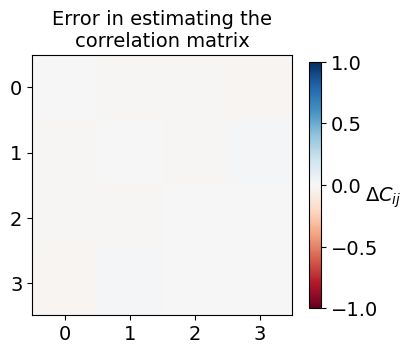

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4.2, 4))
im = ax.imshow(expval_exact-expval_estmt, cmap=plt.get_cmap("RdBu"), vmin=-1, vmax=1)
ax.xaxis.set_ticks(range(num_qubits))
ax.yaxis.set_ticks(range(num_qubits))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title("Error in estimating the\ncorrelation matrix", fontsize=14)

bar = fig.colorbar(im, pad=0.05, shrink=0.80)
bar.set_label(r"$\Delta C_{ij}$", fontsize=14, rotation=0)
bar.ax.tick_params(labelsize=14)
plt.show()

Training Classical Machine Learning Models
==========================================


There are multiple ways in which we can combine classical shadows and
machine learning. This could include training a model to learn the
classical representation of quantum systems based on some system
parameter, estimating a property from such learned classical
representations, or a combination of both. In our case, we consider the
problem of using
`kernel-based models <tutorial_kernel_based_training>`{.interpreted-text
role="doc"} to learn the ground-state representation of the Heisenberg
model Hamiltonian $H(x_l)$ from the coupling vector $x_l$, where
$x_l = [J_{i,j} \text{ for } i < j]$. The goal is to predict the
correlation functions $C_{ij}$:

$$\big\{x_l \rightarrow \sigma_T(\rho(x_l)) \rightarrow \text{Tr}(\hat{C}_{ij} \sigma_T(\rho(x_l))) \big\}_{l=1}^{N}.$$

Here, we consider the following kernel-based machine learning model:

$$\hat{\sigma}_{N} (x) = \sum_{l=1}^{N} \kappa(x, x_l)\sigma_T (x_l) = \sum_{l=1}^{N} \left(\sum_{l^{\prime}=1}^{N} k(x, x_{l^{\prime}})(K+\lambda I)^{-1}_{l, l^{\prime}} \sigma_T(x_l) \right),$$

where $\lambda > 0$ is a regularization parameter in cases when $K$ is
not invertible, $\sigma_T(x_l)$ denotes the classical representation of
the ground state $\rho(x_l)$ of the Heisenberg model constructed using
$T$ randomized Pauli measurements, and $K_{ij}=k(x_i, x_j)$ is the
kernel matrix with $k(x, x^{\prime})$ as the kernel function.

Similarly, estimating an expectation value on the predicted ground state
$\sigma_T(x_l)$ using the trained model can then be done by evaluating:

$$\text{Tr}(\hat{O} \hat{\sigma}_{N} (x)) = \sum_{l=1}^{N} \kappa(x, x_l)\text{Tr}(O\sigma_T (x_l)).$$

We train the classical kernel-based models using $N = 70$ randomly
chosen values of the coupling matrices $J$.


In [22]:
# imports for ML methods and techniques
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge

First, to build the dataset, we use the function `build_dataset` that
takes as input the size of the dataset (`num_points`), the topology of
the lattice (`Nr` and `Nc`), and the number of randomized Pauli
measurements ($T$) for the construction of classical shadows. The
`X_data` is the set of coupling vectors that are defined as a stripped
version of the coupling matrix $J$, where only non-duplicate and
non-zero $J_{ij}$ are considered. The `y_exact` and `y_clean` are the
set of correlation vectors, i.e., the flattened correlation matrix $C$,
computed with respect to the ground-state obtained from exact
diagonalization and classical shadow representation (with $T=500$),
respectively.


In [23]:
def build_dataset(num_points, Nr, Nc, T=500):

    num_qubits = Nr * Nc
    X, y_exact, y_estim = [], [], []
    coupling_mats = build_coupling_mats(num_points, Nr, Nc)

    for coupling_mat in coupling_mats:
        ham = Hamiltonian(coupling_mat)
        eigvals, eigvecs = sp.sparse.linalg.eigs(ham.sparse_matrix())
        psi = eigvecs[:, np.argmin(eigvals)]
        shadow = gen_class_shadow(circuit_oshot, psi, T, num_qubits)

        coups = list(it.product(range(num_qubits), repeat=2))
        corrs = [corr_function(i, j) for i, j in coups]
        qbobs = [x for sublist in corrs for x in sublist]

        expval_exact = build_exact_corrmat(coups, corrs, circuit_exact, psi)
        expval_estim = build_estim_corrmat(coups, corrs, len(qbobs), shadow)

        coupling_vec = []
        for coup in coupling_mat.reshape(1, -1)[0]:
            if coup and coup not in coupling_vec:
                coupling_vec.append(coup)
        coupling_vec = np.array(coupling_vec) / np.linalg.norm(coupling_vec)

        X.append(coupling_vec)
        y_exact.append(expval_exact.reshape(1, -1)[0])
        y_estim.append(expval_estim.reshape(1, -1)[0])

    return np.array(X), np.array(y_exact), np.array(y_estim)

X, y_exact, y_estim = build_dataset(100, Nr, Nc, 500)
X_data, y_data = X, y_estim
X_data.shape, y_data.shape, y_exact.shape

((100, 4), (100, 16), (100, 16))

Now that our dataset is ready, we can shift our focus to the ML models.
Here, we use two different Kernel functions: (i) Gaussian Kernel and
(ii) Neural Tangent Kernel. For both of them, we consider the
regularization parameter $\lambda$ from the following set of values:

$$\lambda = \left\{ 0.0025, 0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 5.0, 10.0 \right\}.$$

Next, we define the kernel functions $k(x, x^{\prime})$ for each of the
mentioned kernels:


$$k(x, x^{\prime}) = e^{-\gamma||x - x^{\prime}||^{2}_{2}}. \tag{Gaussian Kernel}$$

For the Gaussian kernel, the hyperparameter
$\gamma = N^{2}/\sum_{i=1}^{N} \sum_{j=1}^{N} ||x_i-x_j||^{2}_{2} > 0$
is chosen to be the inverse of the average Euclidean distance $x_i$ and
$x_j$. The kernel is implemented using the radial-basis function (rbf)
kernel in the `sklearn` library.


$$k(x, x^{\prime}) = k^{\text{NTK}}(x, x^{\prime}). \tag{Neural Tangent Kernel}$$

The neural tangent kernel $k^{\text{NTK}}$ used here is equivalent to an
infinite-width feed-forward neural network with four hidden layers and
that uses the rectified linear unit (ReLU) as the activation function.
This is implemented using the `neural_tangents` library.


In [24]:
from neural_tangents import stax
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32),
    stax.Relu(),
    stax.Dense(32),
    stax.Relu(),
    stax.Dense(32),
    stax.Relu(),
    stax.Dense(32),
    stax.Relu(),
    stax.Dense(1),
)
kernel_NN = kernel_fn(X_data, X_data, "ntk")

for i in range(len(kernel_NN)):
    for j in range(len(kernel_NN)):
        kernel_NN.at[i, j].set((kernel_NN[i][i] * kernel_NN[j][j]) ** 0.5)

For the above two defined kernel methods, we obtain the best learning
model by performing hyperparameter tuning using cross-validation for the
prediction task of each $C_{ij}$. For this purpose, we implement the
function `fit_predict_data`, which takes input as the correlation
function index `cij`, kernel matrix `kernel`, and internal kernel
mapping `opt` required by the kernel-based regression models from the
`sklearn` library.


In [25]:
from sklearn.metrics import mean_squared_error

def fit_predict_data(cij, kernel, opt="linear"):

    # training data (estimated from measurement data)
    y = np.array([y_estim[i][cij] for i in range(len(X_data))])
    X_train, X_test, y_train, y_test = train_test_split(
        kernel, y, test_size=0.3, random_state=24
    )

    # testing data (exact expectation values)
    y_clean = np.array([y_exact[i][cij] for i in range(len(X_data))])
    _, _, _, y_test_clean = train_test_split(kernel, y_clean, test_size=0.3, random_state=24)

    # hyperparameter tuning with cross validation
    models = [
        # Epsilon-Support Vector Regression
        (lambda Cx: svm.SVR(kernel=opt, C=Cx, epsilon=0.1)),
        # Kernel-Ridge based Regression
        (lambda Cx: KernelRidge(kernel=opt, alpha=1 / (2 * Cx))),
    ]

    # Regularization parameter
    hyperparams = [0.0025, 0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 5.0, 10.0]
    best_pred, best_cv_score, best_test_score = None, np.inf, np.inf
    for model in models:
        for hyperparam in hyperparams:
            cv_score = -np.mean(
                cross_val_score(
                    model(hyperparam), X_train, y_train, cv=5,
                    scoring="neg_root_mean_squared_error",
                )
            )
            if best_cv_score > cv_score:
                best_model = model(hyperparam).fit(X_train, y_train)
                best_pred = best_model.predict(X_test)
                best_cv_score = cv_score
                best_test_score = mean_squared_error(
                    best_model.predict(X_test).ravel(), y_test_clean.ravel(), squared=False
                )

    return (
        best_pred, y_test_clean, np.round(best_cv_score, 5), np.round(best_test_score, 5)
    )

We perform the fitting and prediction for each $C_{ij}$ and print the
output in a tabular format.


In [26]:
kernel_list = ["Gaussian kernel", "Neural Tangent kernel"]
kernel_data = np.zeros((num_qubits ** 2, len(kernel_list), 2))
y_predclean, y_predicts1, y_predicts2 = [], [], []

for cij in range(num_qubits ** 2):
    y_predict, y_clean, cv_score, test_score = fit_predict_data(cij, X_data, opt="rbf")
    y_predclean.append(y_clean)
    kernel_data[cij][0] = (cv_score, test_score)
    y_predicts1.append(y_predict)
    y_predict, y_clean, cv_score, test_score = fit_predict_data(cij, kernel_NN)
    kernel_data[cij][1] = (cv_score, test_score)
    y_predicts2.append(y_predict)

# For each C_ij print (best_cv_score, test_score) pair
row_format = "{:>25}{:>35}{:>35}"
print(row_format.format("Correlation", *kernel_list))
for idx, data in enumerate(kernel_data):
    print(
        row_format.format(
            f"\t C_{idx//num_qubits}{idx%num_qubits} \t| ",
            str(data[0]),
            str(data[1]),
        )
    )

              Correlation                    Gaussian kernel              Neural Tangent kernel
               	 C_00 	|                           [-0.  0.]                          [-0.  0.]
               	 C_01 	|                   [0.09871 0.06988]                  [0.12886 0.06494]
               	 C_02 	|                   [0.10078 0.06333]                  [0.10897 0.07771]
               	 C_03 	|                   [0.09489 0.0417 ]                  [0.10066 0.05993]
               	 C_10 	|                   [0.09871 0.06988]                  [0.12886 0.06494]
               	 C_11 	|                           [-0.  0.]                          [-0.  0.]
               	 C_12 	|                   [0.11153 0.03719]                  [0.11597 0.05878]
               	 C_13 	|                     [0.1052 0.0649]                  [0.11276 0.08506]
               	 C_20 	|                   [0.10078 0.06333]                  [0.10897 0.07771]
               	 C_21 	|                

Overall, we find that the models with the Gaussian kernel performed
better than those with NTK for predicting the expectation value of the
correlation function $C_{ij}$ for the ground state of the Heisenberg
model. However, the best choice of $\lambda$ differed substantially
across the different $C_{ij}$ for both kernels. We present the predicted
correlation matrix $C^{\prime}$ for randomly selected Heisenberg models
from the test set below for comparison against the actual correlation
matrix $C$, which is obtained from the ground state found using exact
diagonalization.


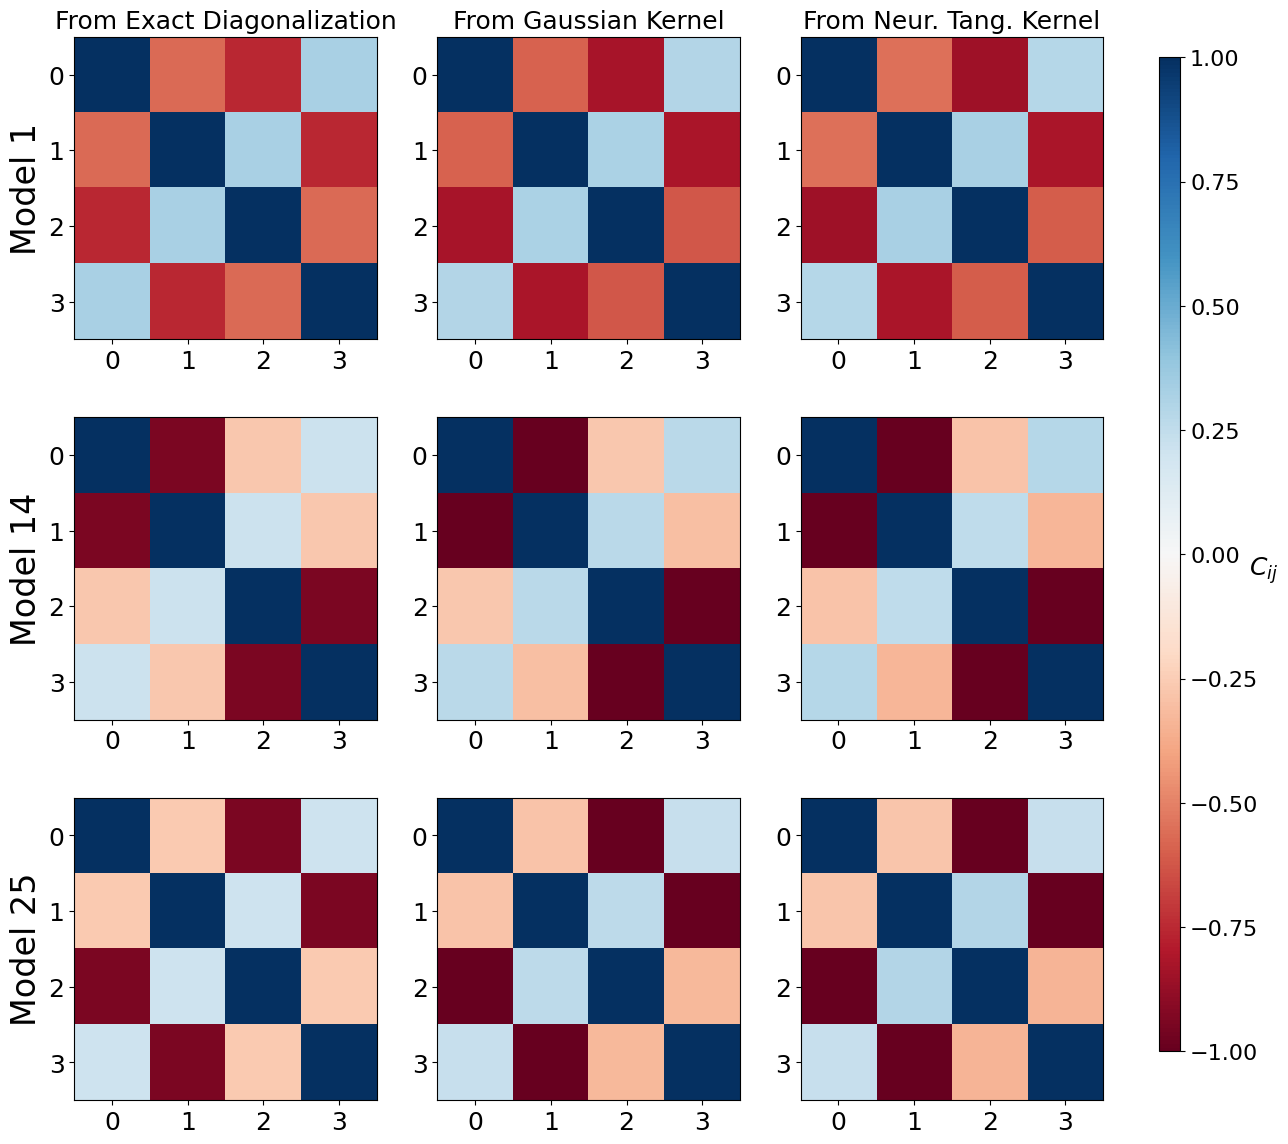

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(14, 14))
corr_vals = [y_predclean, y_predicts1, y_predicts2]
plt_plots = [1, 14, 25]

cols = [
    "From {}".format(col)
    for col in ["Exact Diagonalization", "Gaussian Kernel", "Neur. Tang. Kernel"]
]
rows = ["Model {}".format(row) for row in plt_plots]

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=18)

for ax, row in zip(axes[:, 0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=24)

for itr in range(3):
    for idx, corr_val in enumerate(corr_vals):
        shw = axes[itr][idx].imshow(
            np.array(corr_vals[idx]).T[plt_plots[itr]].reshape(Nr * Nc, Nr * Nc),
            cmap=plt.get_cmap("RdBu"), vmin=-1, vmax=1,
        )
        axes[itr][idx].xaxis.set_ticks(range(Nr * Nc))
        axes[itr][idx].yaxis.set_ticks(range(Nr * Nc))
        axes[itr][idx].xaxis.set_tick_params(labelsize=18)
        axes[itr][idx].yaxis.set_tick_params(labelsize=18)

fig.subplots_adjust(right=0.86)
cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.71])
bar = fig.colorbar(shw, cax=cbar_ax)

bar.set_label(r"$C_{ij}$", fontsize=18, rotation=0)
bar.ax.tick_params(labelsize=16)
plt.show()

Finally, we also attempt to showcase the effect of the size of training
data $N$ and the number of Pauli measurements $T$. For this, we look at
the average root-mean-square error (RMSE) in prediction for each kernel
over all two-point correlation functions $C_{ij}$. Here, the first plot
looks at the different training sizes $N$ with a fixed number of
randomized Pauli measurements $T=100$. In contrast, the second plot
looks at the different shadow sizes $T$ with a fixed training data size
$N=70$. The performance improvement seems to be saturating after a
sufficient increase in $N$ and $T$ values for all two kernels in both
the cases.


![image](/demonstrations/ml_classical_shadows/rmse_training.png){width="47.0%"}

![image](/demonstrations/ml_classical_shadows/rmse_shadow.png){width="47.0%"}


Conclusion
==========

This demo illustrates how classical machine learning models can benefit
from the classical shadow formalism for learning characteristics and
predicting the behavior of quantum systems. As argued in Ref., this
raises the possibility that models trained on experimental or quantum
data data can effectively address quantum many-body problems that cannot
be solved using classical methods alone.


In [28]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1700501668.4348798
Mon Nov 20 17:34:28 2023


References {#ml_classical_shadow_references}
==========

About the author
================
